In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook uses Tensorflow and CNN to develop a simple baseline model architecture for image recognition.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.applications import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import cv2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pandas as pd
mpl.rcParams['figure.dpi']=100

In [ ]:
%cd /content/drive/MyDrive/DataSpikeFolder

/content/drive/.shortcut-targets-by-id/17hBStt627ZzpuCOKhHeNMxcSth_XTsZG/DataSpikeFolder


**Read all images from the Data.csv file and split into Train and Validation. Further inference data was derived from the Validation images**

In [ ]:
dataset = pd.read_csv('data.csv')
dataset['Label'].value_counts()

original    1972
tampered     857
Name: Label, dtype: int64

In [ ]:
len(dataset)

2829

In [ ]:
# Create a new DataFrame to store non-duplicate files
non_duplicate_df = pd.DataFrame(columns=['Path', 'Label'])

# Extract file names from the file paths
dataset['file_name'] = dataset['Path'].apply(lambda x: x.split('/')[-1])

# Find non-duplicate file names
non_duplicate_file_names = dataset['file_name'].value_counts()[dataset['file_name'].value_counts() == 1].index

# Filter the original DataFrame for non-duplicate files
non_duplicate_files = dataset[dataset['file_name'].isin(non_duplicate_file_names)]

# Add non-duplicate files to the new DataFrame
non_duplicate_df['Path'] = non_duplicate_files['Path']
non_duplicate_df['Label'] = non_duplicate_files['Label']

# Now non_duplicate_df contains the details of non-duplicate files
print(non_duplicate_df.shape)

(1977, 2)


In [ ]:
non_duplicate_df.head()

,Path,Label
0,dataset/MICC-F220/DSCF6_scale.jpg,original
1,dataset/MICC-F220/DSCF5_scale.jpg,original
2,dataset/MICC-F220/DSCF4_scale.jpg,original
3,dataset/MICC-F220/DSCF3_scale.jpg,original
4,dataset/MICC-F220/DSCF2_scale.jpg,original


In [ ]:
non_duplicate_df["Label"].value_counts()

original    1136
tampered     841
Name: Label, dtype: int64

In [ ]:
# Create a new DataFrame to store non-duplicate files
duplicate_df = pd.DataFrame(columns=['Path', 'Label'])

# Extract file names from the file paths
dataset['file_name'] = dataset['Path'].apply(lambda x: x.split('/')[-1])

# Find non-duplicate file names
duplicate_file_names = dataset['file_name'].value_counts()[dataset['file_name'].value_counts() > 1].index

# Filter the original DataFrame for non-duplicate files
duplicate_files = dataset[dataset['file_name'].isin(duplicate_file_names)]

# Add non-duplicate files to the new DataFrame
duplicate_df['Path'] = duplicate_files['Path']
duplicate_df['Label'] = duplicate_files['Label']

# Now duplicate_df contains the details of non-duplicate files
print(duplicate_df.shape)

(852, 2)


In [ ]:
duplicate_df["Label"].value_counts()

original    836
tampered     16
Name: Label, dtype: int64

In [ ]:
# get valid data from non_duplicate df
train, valid = train_test_split(non_duplicate_df, test_size=0.12, shuffle=True, random_state=421)
print(len(valid))

238


In [ ]:
valid["Label"].value_counts()

original    138
tampered    100
Name: Label, dtype: int64

In [ ]:
# get test data fraction from valid
valid_, test = train_test_split(valid, test_size=0.03, shuffle=True, random_state=422)
print(len(test))

8


In [ ]:
test["Label"].value_counts()

tampered    5
original    3
Name: Label, dtype: int64

In [ ]:
remaining_df = pd.concat([train, duplicate_df], axis=0)
print(len(remaining_df))

2591


In [ ]:
shuffled_train_df = remaining_df.sample(frac=1, random_state=421)

In [ ]:
shuffled_train_df["Label"].value_counts()

original    1834
tampered     757
Name: Label, dtype: int64

In [ ]:
## export data sets
shuffled_train_df.to_csv("train.csv", index=False)
valid_.to_csv("valid.csv", index=False)
test.to_csv("test.csv", index=False)

In [ ]:
print("train size: ", len(shuffled_train_df))
print("valid size: ", len(valid_))
print("test size: ", len(test))

train size:  2591
valid size:  230
test size:  8


In [ ]:
# Filter rows based on file extensions
extensions = ['.jpg', '.jpeg', '.png']

train = shuffled_train_df[shuffled_train_df['Path'].str.lower().str.endswith(tuple(extensions))]
print(train.shape)

valid = valid_[valid_['Path'].str.lower().str.endswith(tuple(extensions))]
print(valid.shape)

test = test[test['Path'].str.lower().str.endswith(tuple(extensions))]
print(test.shape)

(2590, 2)
(230, 2)
(8, 2)


In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

**Below is the data preprocessing step for the Train and validation data path using OpenCV and TensorFlow to read, resize, normalize and convert all images to a TensorFlow tensor format.**

In [ ]:
x = []
dim = (128,128)
for i in tqdm(train["Path"]):
  try:
    img = cv2.imread('.'+'/{}'.format(i))
    if len(img.shape) > 2 and img.shape[2] == 4:
        # convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, dim)
    # normalise the images
    img = img/255
    img_to_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
  except:
    print(i)
  x.append(img_to_tensor)

trainX_tensor = tf.stack(x)

100%|██████████| 2590/2590 [28:52<00:00,  1.50it/s]


In [ ]:
x = []
dim = (128,128)
for i in tqdm(valid["Path"]):
  try:
    img = cv2.imread('.'+'/{}'.format(i))
    if len(img.shape) > 2 and img.shape[2] == 4:
        # convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, dim)
    # normalise the images
    img = img/255
    img_to_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
  except:
    print(i)
  x.append(img_to_tensor)

validX_tensor = tf.stack(x)

100%|██████████| 230/230 [02:29<00:00,  1.53it/s]


In [ ]:
# Convert labels to numeric values (assuming 0 for negative class and 1 for positive class)
train['Label'] = train['Label'].apply(lambda label: 1 if label == 'original' else 0)
valid['Label'] = valid['Label'].apply(lambda label: 1 if label == 'original' else 0)

# Convert labels to TensorFlow tensor
trainY = tf.convert_to_tensor(train['Label'].values, dtype=tf.float32)
validY = tf.convert_to_tensor(valid['Label'].values, dtype=tf.float32)

In [ ]:
validY

<tf.Tensor: shape=(230,), dtype=float32, numpy=
array([1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1

Simple Model Architecture for a Baseline

**Below is the convolutional neural network(CNN) Model using the Keras library in Tensorflow, setting input shape (128,128,3) and size 128x128 pixels and using a linear stake of layers (Sequential)**

In [ ]:
in_shape = (128,128,3)
batch_size = 8

model = Sequential()
model.add(keras.Input(shape=in_shape))
model.add(Conv2D(128, 4, strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, 4, strides=2, activation="relu"))
# model.add(Conv2D(64, 4, strides=2, activation="relu"))
# model.add(Dropout(0.5))
model.add(Conv2D(64, 3, strides=2, activation="relu"))
model.add(MaxPooling2D(3))

model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 128)       6272      
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       262272    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 64)         0         
 )                                                               
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0

**This is the visual representation of the model architecture, which includes the shapes of the input and output tensors including the name of each layers**

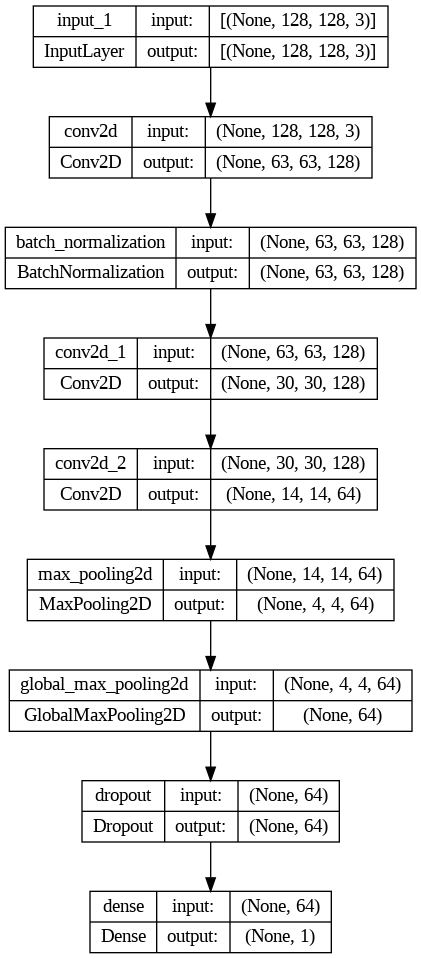

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

**This prepares the optimizer, compiles the model and set up the Earlystopping and modelcheckpoint callbacks to  prevent overfitting and save the best model weights.(best_baseline.h5)**


In [ ]:
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

opt  = SGD(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the 'baseline/weights/best_baseline2.h5' file
with open('baseline/weights/best_baseline2.h5', 'w') as f:
  pass

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='baseline/weights/best_baseline2.h5',
                                 save_best_only=True,
                                 save_weights_only=True)]

In [19]:
## Model training
history = model.fit(x=trainX_tensor, y=trainY, validation_data=(validX_tensor, validY),
                  batch_size=batch_size,verbose=2, callbacks=callbacks, epochs=15)

Epoch 1/10
319/319 - 140s - loss: 0.8322 - accuracy: 0.5717 - val_loss: 0.6681 - val_accuracy: 0.6259 - 140s/epoch - 439ms/step
Epoch 2/10
319/319 - 132s - loss: 0.7990 - accuracy: 0.5678 - val_loss: 0.6429 - val_accuracy: 0.6259 - 132s/epoch - 414ms/step
Epoch 3/10
319/319 - 140s - loss: 0.7227 - accuracy: 0.6059 - val_loss: 0.6122 - val_accuracy: 0.6403 - 140s/epoch - 439ms/step
Epoch 4/10
319/319 - 137s - loss: 0.7107 - accuracy: 0.6173 - val_loss: 0.6066 - val_accuracy: 0.6331 - 137s/epoch - 429ms/step
Epoch 5/10
319/319 - 138s - loss: 0.6887 - accuracy: 0.6314 - val_loss: 0.5804 - val_accuracy: 0.6691 - 138s/epoch - 433ms/step
Epoch 6/10
319/319 - 139s - loss: 0.6457 - accuracy: 0.6436 - val_loss: 0.5685 - val_accuracy: 0.6763 - 139s/epoch - 436ms/step
Epoch 7/10
319/319 - 133s - loss: 0.6459 - accuracy: 0.6613 - val_loss: 0.5585 - val_accuracy: 0.6727 - 133s/epoch - 418ms/step
Epoch 8/10
319/319 - 140s - loss: 0.6072 - accuracy: 0.6845 - val_loss: 0.5513 - val_accuracy: 0.6799 - 

In [ ]:
# FORMER RESULT: *Not to be used as the validation data was in train data
# Epoch 10/10
# 319/319 - 139s - loss: 0.5862 - accuracy: 0.7018 - val_loss: 0.4754 - val_accuracy: 0.7482

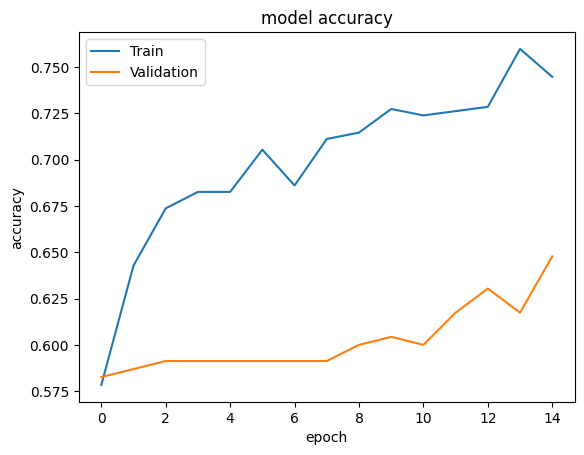

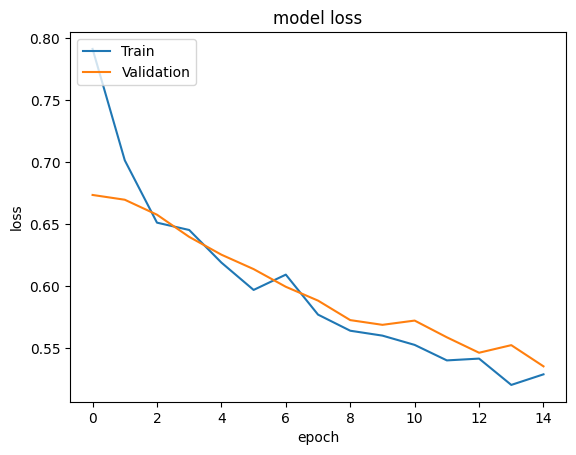

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**__ First Inference__**

In [ ]:
print(test["Path"][2])

dataset/MICC-F2000/PA260237tamp8.jpg


In [ ]:
import timeit
# Reload the model
# model = keras.models.load_model('baseline/weights/best_baseline.h5')

# Load the image
for image in test["Path"]:
  img = cv2.imread(image)
  img = cv2.resize(img, (128, 128))
  img = img / 255.0
  img = tf.expand_dims(img, axis=0)

  # Get the inference time
  start_time = timeit.default_timer()
  predictions = model.predict(img)
  end_time = timeit.default_timer()
  inference_time = end_time - start_time

  # Print the inference time
  print(f'The inference time is: {inference_time:.2f} ms')

  # Get the predicted class
  predicted_class = predictions[0][0]

  # Print the predicted class
  print(f'The predicted class for {image} is: {predicted_class}')

1/1 [==============================] - 0s 176ms/step
The inference time is: 0.25 ms
The predicted class for dataset/MICC-F2000/DSC_1426_scale.jpg is: 0.7668447494506836
1/1 [==============================] - 0s 39ms/step
The inference time is: 0.09 ms
The predicted class for dataset/MICC-F2000/DSC_1034_scale.jpg is: 0.7710500359535217
1/1 [==============================] - 0s 39ms/step
The inference time is: 0.09 ms
The predicted class for dataset/MICC-F2000/PA260237tamp8.jpg is: 0.5729145407676697
1/1 [==============================] - 0s 45ms/step
The inference time is: 0.11 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp6.jpg is: 0.7841464877128601
1/1 [==============================] - 0s 36ms/step
The inference time is: 0.09 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp8.jpg is: 0.7766059637069702
1/1 [==============================] - 0s 40ms/step
The inference time is: 0.09 ms
The predicted class for dataset/MICC-F2000/DSC_0409tamp1.jpg is: 0.496220111846

Higher proobabilities represent the original.

## Data Augmentation

Apply data augmentation and class weights to compare result with baseline.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

dim = (128, 128)

# Create an instance of ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate images randomly by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.2,        # Apply shear transformations
    zoom_range=0.2,         # Zoom in/out on images
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=False,    # Don't flip images vertically
    fill_mode='nearest'     # Fill in newly created pixels using the nearest existing pixel
)

x_augmented = []
y_augmented = []

# Loop through each image path in the dataframe
for i in tqdm(range(len(train))):
    try:
        img = cv2.imread('.' + '/{}'.format(train["Path"][i]))
        if len(img.shape) > 2 and img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(img, dim)
        img = img / 255
        img_augmented = datagen.random_transform(img)  # Apply random augmentation
        img_to_tensor = tf.convert_to_tensor(img_augmented, dtype=tf.float32)
    except:
        print(i)
    x_augmented.append(img_to_tensor)
    y_augmented.append(train['Label'][i])

trainX_augmented_tensor = tf.stack(x_augmented)
trainY_augmented = tf.convert_to_tensor(y_augmented, dtype=tf.float32)

# Combine the original and augmented data tensors
combined_trainX_tensor = tf.concat([trainX_tensor, trainX_augmented_tensor], axis=0)

# Combine the original and augmented label tensors
combined_trainY = tf.concat([trainY, trainY_augmented], axis=0)

100%|██████████| 2590/2590 [03:40<00:00, 11.77it/s]


In [ ]:
## AUGMENT THE VALIDATION DATA TOO TO AVOID OVERFITTING

dim = (128, 128)

# Create an instance of ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate images randomly by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the height
    shear_range=0.2,        # Apply shear transformations
    zoom_range=0.2,         # Zoom in/out on images
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=False,    # Don't flip images vertically
    fill_mode='nearest'     # Fill in newly created pixels using the nearest existing pixel
)

x_augmented = []
y_augmented = []

# Loop through each image path in the dataframe
for i in tqdm(range(len(valid))):
    try:
        img = cv2.imread('.' + '/{}'.format(valid["Path"][i]))
        if len(img.shape) > 2 and img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(img, dim)
        img = img / 255
        img_augmented = datagen.random_transform(img)  # Apply random augmentation
        img_to_tensor = tf.convert_to_tensor(img_augmented, dtype=tf.float32)
    except:
        print(i)
    x_augmented.append(img_to_tensor)
    y_augmented.append(valid['Label'][i])

validX_augmented_tensor = tf.stack(x_augmented)
validY_augmented = tf.convert_to_tensor(y_augmented, dtype=tf.float32)

# Combine the original and augmented data tensors
combined_validX_tensor = tf.concat([validX_tensor, validX_augmented_tensor], axis=0)

# Combine the original and augmented label tensors
combined_validY = tf.concat([validY, validY_augmented], axis=0)

100%|██████████| 230/230 [00:19<00:00, 11.73it/s]


In [ ]:
# Verify the shapes of the combined tensors
print("Shape of combined train data tensor:", combined_trainX_tensor.shape)
print("Shape of combined train label tensor:", combined_trainY.shape)

print("Shape of combined valid data tensor:", combined_validX_tensor.shape)
print("Shape of combined valid label tensor:", combined_validY.shape)

Shape of combined train data tensor: (5180, 128, 128, 3)
Shape of combined train label tensor: (5180,)
Shape of combined valid data tensor: (460, 128, 128, 3)
Shape of combined valid label tensor: (460,)


In [ ]:
in_shape = (128,128,3)
batch_size = 8

model = Sequential()
model.add(keras.Input(shape=in_shape))
model.add(Conv2D(128, 4, strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, 4, strides=2, activation="relu"))
# model.add(Conv2D(64, 4, strides=2, activation="relu"))
# model.add(Dropout(0.5))
model.add(Conv2D(64, 3, strides=2, activation="relu"))
model.add(MaxPooling2D(3))

model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 63, 63, 128)       6272      
                                                                 
 batch_normalization_2 (Batc  (None, 63, 63, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       262272    
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 global_max_pooling2d_2 (Glo  (None, 64)              

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['Label']),
                                        y = train['Label']
                                    )
class_weights = dict(zip(np.unique(train['Label']), class_weights))
class_weights

{0: 1.7107001321003963, 1: 0.7064920894708129}

In [ ]:
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

opt = SGD(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the 'baseline/weights/best_baseline_with_augmentation.h5' file
with open('baseline/weights/best_baseline_with_augmentation.h5', 'w') as f:
  pass

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0),
    ModelCheckpoint(
        filepath='baseline/weights/best_baseline_with_augmentation.h5',
        save_best_only=True,
        save_weights_only=True
    )
]

# Train the model using class weights
history = model.fit(x=combined_trainX_tensor, y=combined_trainY, validation_data=(combined_validX_tensor, combined_validY),
                  batch_size=batch_size,verbose=2, callbacks=callbacks, epochs=50, class_weight=class_weights)



Epoch 1/50
648/648 - 7s - loss: 0.7332 - accuracy: 0.5490 - val_loss: 0.6504 - val_accuracy: 0.6630 - 7s/epoch - 11ms/step
Epoch 2/50
648/648 - 5s - loss: 0.6580 - accuracy: 0.6149 - val_loss: 0.6271 - val_accuracy: 0.6913 - 5s/epoch - 8ms/step
Epoch 3/50
648/648 - 5s - loss: 0.6325 - accuracy: 0.6502 - val_loss: 0.6034 - val_accuracy: 0.7457 - 5s/epoch - 8ms/step
Epoch 4/50
648/648 - 5s - loss: 0.6018 - accuracy: 0.6873 - val_loss: 0.5839 - val_accuracy: 0.7630 - 5s/epoch - 8ms/step
Epoch 5/50
648/648 - 5s - loss: 0.5822 - accuracy: 0.7156 - val_loss: 0.5876 - val_accuracy: 0.6761 - 5s/epoch - 8ms/step
Epoch 6/50
648/648 - 5s - loss: 0.5575 - accuracy: 0.7365 - val_loss: 0.5624 - val_accuracy: 0.7457 - 5s/epoch - 8ms/step
Epoch 7/50
648/648 - 5s - loss: 0.5465 - accuracy: 0.7506 - val_loss: 0.5489 - val_accuracy: 0.7761 - 5s/epoch - 8ms/step
Epoch 8/50
648/648 - 5s - loss: 0.5251 - accuracy: 0.7681 - val_loss: 0.5252 - val_accuracy: 0.7957 - 5s/epoch - 8ms/step
Epoch 9/50
648/648 - 5s

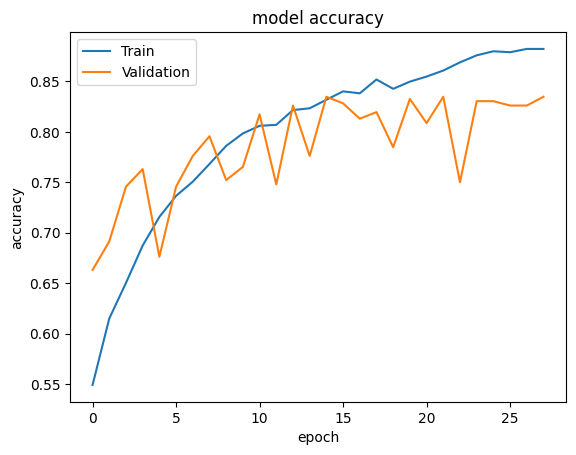

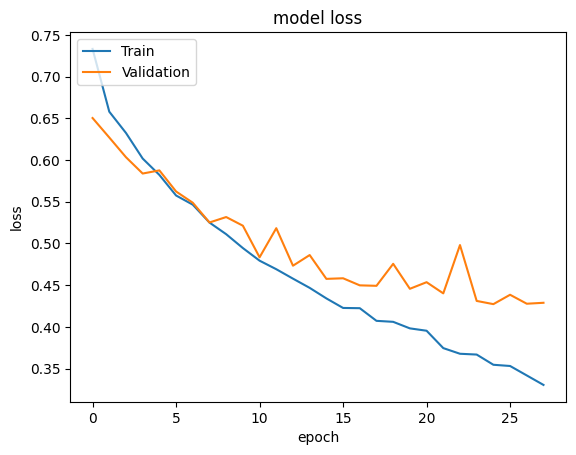

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import timeit
# Reload the model
# model = keras.models.load_model('baseline/weights/best_baseline.h5')

# Load the image
for image in test["Path"]:
  img = cv2.imread(image)
  img = cv2.resize(img, (128, 128))
  img = img / 255.0
  img = tf.expand_dims(img, axis=0)

  # Get the inference time
  start_time = timeit.default_timer()
  predictions = model.predict(img)
  end_time = timeit.default_timer()
  inference_time = end_time - start_time

  # Print the inference time
  print(f'The inference time is: {inference_time:.2f} ms')

  # Get the predicted class
  predicted_class = predictions[0][0]

  # Print the predicted class
  print(f'The predicted class for {image} is: {predicted_class}')

1/1 [==============================] - 1s 514ms/step
The inference time is: 0.58 ms
The predicted class for dataset/MICC-F2000/DSC_1426_scale.jpg is: 0.8973434567451477
1/1 [==============================] - 0s 37ms/step
The inference time is: 0.11 ms
The predicted class for dataset/MICC-F2000/DSC_1034_scale.jpg is: 0.6210706830024719
1/1 [==============================] - 0s 19ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/PA260237tamp8.jpg is: 0.03718969598412514
1/1 [==============================] - 0s 30ms/step
The inference time is: 0.07 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp6.jpg is: 0.15629424154758453
1/1 [==============================] - 0s 27ms/step
The inference time is: 0.08 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp8.jpg is: 0.13289421796798706
1/1 [==============================] - 0s 27ms/step
The inference time is: 0.08 ms
The predicted class for dataset/MICC-F2000/DSC_0409tamp1.jpg is: 0.021772213